# Bike Anomaly Storytelling
### Ian Klasky
#### Nov 23 , 2020

This notebook tells the story of finding an anomaly in data. Specifically, I'll be looking at the Boston Bluebikes data.

## Importing Basic Packages & Data<a name="Importing"></a>

In [1]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Greater Boston's Bluebikes bikesharing program publishes its trip data once a month to a csv on its [website](https://s3.amazonaws.com/hubway-data/index.html), making it easy to collect for this project.

I downloaded the available data from January 2017, all the way up to June 2020. We can see the first 3 entries from the dataset in a pandas dataframe below.

In [2]:
def read_all_csvs(df):
    
    path = './data/blue_bikes_trip_data/'
    for file in sorted(os.listdir(path))[2:]:
        df_new = pd.read_csv(path+file, index_col=1, parse_dates=True)
        frames = [df,df_new]
        df = pd.concat(frames)
        
    return df

In [3]:
df = pd.read_csv('data/blue_bikes_trip_data/201701-hubway-tripdata.csv', index_col=1, parse_dates=True)

df = read_all_csvs(df)

df.head(3)

,tripduration,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,postal code
starttime,,,,,,,,,,,,,,,
2017-01-01 00:06:58,350,2017-01-01 00:12:49,67,MIT at Mass Ave / Amherst St,42.358100,-71.093198,139,Dana Park,42.361780,-71.108100,644,Subscriber,1988,1.0,NaN
2017-01-01 00:13:16,891,2017-01-01 00:28:07,36,Boston Public Library - 700 Boylston St.,42.349673,-71.077303,10,B.U. Central - 725 Comm. Ave.,42.350406,-71.108279,230,Subscriber,1983,1.0,NaN
2017-01-01 00:16:17,1672,2017-01-01 00:44:10,36,Boston Public Library - 700 Boylston St.,42.349673,-71.077303,9,Agganis Arena - 925 Comm Ave.,42.351246,-71.115639,980,Customer,\N,0.0,NaN


## Formatting & Cleaning Data<a name="Formatting"></a>

This dataframe contains information on each trip logged by the system in chronological order. However, for this analysis we're interested in the total number of trips the system logged each day. This requires us to group the rides by calendar day and sum the total number of trips in each daily group. These steps yield the dataframe below, which consists of the number of rides for each recorded day (zero-indexed).

In [4]:
def trips_per_day(df):
    
    daily_data = df.groupby([pd.Grouper(freq='D')]).count().reset_index().iloc[:, : 2]
    daily_data.columns = ['date','trips']
    
    return daily_data

In [5]:
daily_data = trips_per_day(df)
daily_data

,date,trips
0,2017-01-01,481
1,2017-01-02,802
2,2017-01-03,651
3,2017-01-04,1534
4,2017-01-05,1330
...,...,...
1364,2020-09-26,14174
1365,2020-09-27,10857
1366,2020-09-28,8680
1367,2020-09-29,9696


Many time series models require data to be presented in uniform intervals of time. There are two days in our dataframe that have no recorded trip data. Background research revealed that there were major storms (nor’ easters) occurring in the area on those days and in at least one case, the Bluebikes service was shut down for the day. I imputed 0’s for both days to make the data uniformly spaced in time.

In [6]:
def fix_dates(daily_data):
    
    if 'date' in daily_data.columns:
        daily_data=daily_data.set_index('date')
        daily_data.index = daily_data.index.date

        daily_data.loc[dt.datetime.strptime('2018-03-13', '%Y-%m-%d').date()] = [0]
        daily_data.loc[dt.datetime.strptime('2019-01-20', '%Y-%m-%d').date()] = [0]

    daily_data.sort_index(inplace=True)
    daily_data.index.rename('date',inplace=True)
    daily_data.reset_index(inplace=True)
    
    return daily_data

In [7]:
daily_data = fix_dates(daily_data)

We can see the time series of the daily blue bike rides in greater Boston from 2017 to 2020 below.

In [8]:
def plot_ts(daily_data):
    
    plt.figure(figsize=(13, 8))
    plt.plot(daily_data.date,daily_data.trips)
    
    plt.title('Bluebike trips per day')
    plt.ylabel('Trips',rotation=0,size=15)
    plt.xlabel('Date',rotation=0,size=15)
    plt.tick_params(axis='x', which='major', labelsize=13)
    plt.show()
    
    return

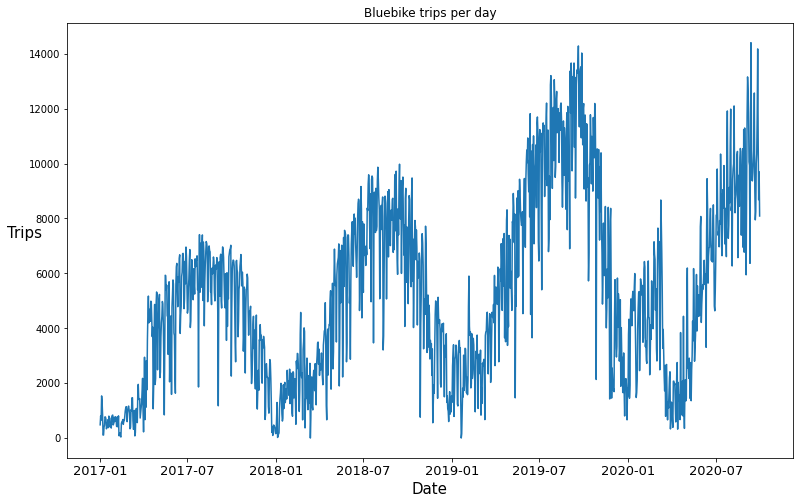

In [9]:
plot_ts(daily_data)

We can see an annual seasonal trend for about the first 3 years of this data. However, around the time the statewide COVID-induced state of emergency was declared on March 11th we see a massive drop-off in daily rides.

In the next section of this analysis we will begin by using an anomaly detection algorithm to try to find quantitative evidence for having observed anomalous utilization in the middle of March.

## Anomaly Detection<a name="Anomaly"></a>

We could rationalize the steep mid-March decline in Bluebikes utilization as being caused by the state of Massachusetts entering a state of emergency around that time. However, it might be good to have *some* quantitative evidence that this behavior isn't in realm of behaviors we could expect from our system based on how the rest of our time series is structured.

We'll be using isolation forests to detect anomalies in our time series. This machine learning algorithm is [known](http://www.cloudbus.org/papers/AnomalyDetectionCloud-CCPE2017.pdf) for its speediness, along with its ability to work well on time series with seasonalities. (We'll discuss seasonalities with respect to this project in greater detail in the *Forecasting Model Selection* section.)

In the cell below, we will construct an isolation forest with our daily trip data, and it will output a similar graph of utilization over time, but with the anomolous days of utilization colored in red.

In [10]:
from sklearn.ensemble import IsolationForest

In [11]:
def isolation_forest(ts):
    
    ts_IF = ts.copy()

    clf=IsolationForest(n_estimators=10, max_samples='auto', contamination=float(.01), \
                            max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0,behaviour='new')
    clf.fit(ts_IF.drop('date',axis=1))
    ts_IF['scores']=clf.decision_function(ts_IF.drop('date',axis=1))
    ts_IF['anomaly']=clf.predict(ts_IF.drop(['date','scores'],axis=1))
    ts_IF.head()
    ts_IF.loc[ts_IF['anomaly'] == 1,'anomaly'] = 0
    ts_IF.loc[ts_IF['anomaly'] == -1,'anomaly'] = 1

    plt.figure(figsize=(17, 8))
    plt.scatter(ts_IF['date'],ts_IF['trips'],c=ts_IF['anomaly'],cmap='bwr',s=60)
    plt.plot(ts_IF['date'],ts_IF['trips'],alpha=0.5)
    plt.show()
    
    return ts_IF

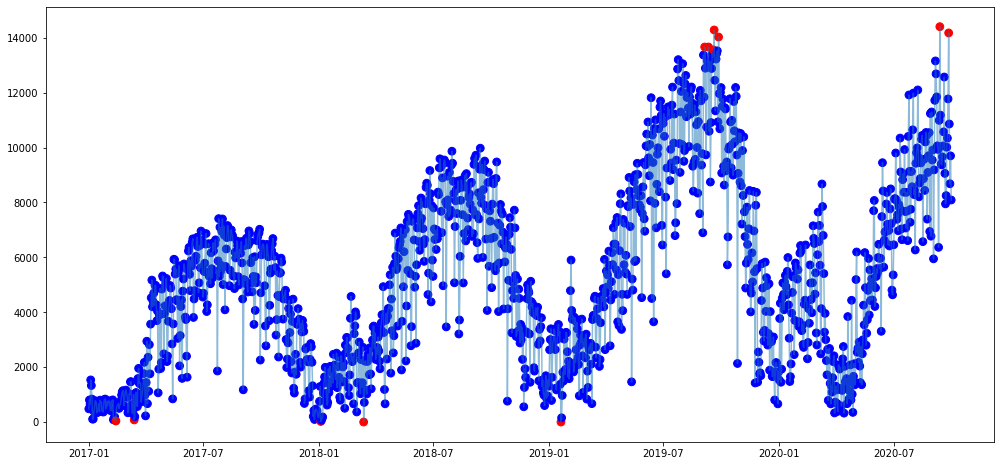

In [12]:
daily_data_IF = isolation_forest(daily_data)

While the isolation forest seemed to capture some of extreme values in the time series, we can see that it probably couldn't understand the seasonal nature of our time series well enough to understand what ws normal for different times of the year.

We will re-run our isolation forest model, but now we will difference our original time series by the number of days in a year, and the number of days in a week. This should negate seasonal effects that might've been tripping up or anomaly detection.

The graph below shows our twice-differenced time series with the points our isolation forest identified as anomolous in red.

In [13]:
def diff_df(daily_data,first_diff,second_diff):
    
    diff_len_1 = first_diff
    diff_len_2 = second_diff

    trips_diff = daily_data['trips'].diff(diff_len_1).iloc[diff_len_1:].diff(diff_len_2).iloc[diff_len_2:]
    date = daily_data['date'].iloc[diff_len_1:].iloc[diff_len_2:]

    daily_data_diff = pd.concat([date,trips_diff],axis=1)
    daily_data_diff['trips'] = daily_data_diff['trips'].astype('int64')
    
    return daily_data_diff

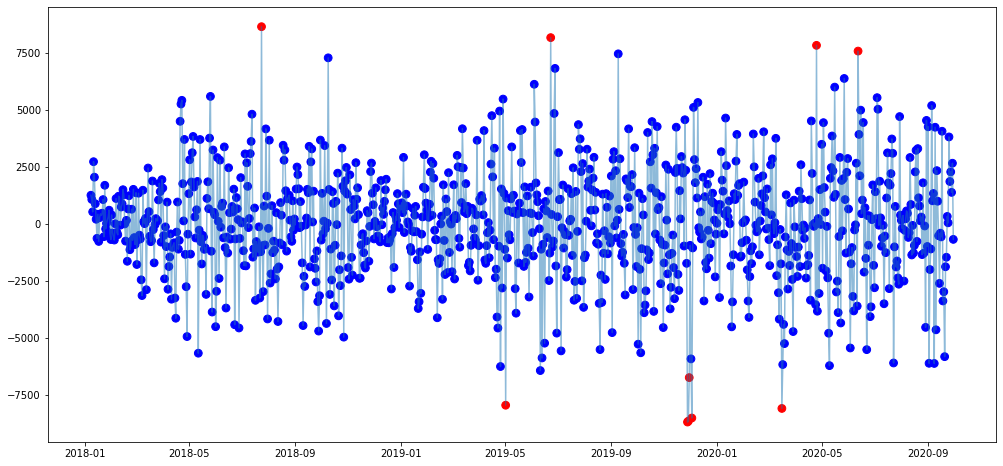

In [14]:
daily_data_diff = diff_df(daily_data,365,7)
daily_data_diff_IF = isolation_forest(daily_data_diff)

The graph below shows our original time series plot, but with the anomolous days from the differenced plot colored in red.

In [15]:
def anomaly_plot(daily_data,daily_data_diff_IF,first_diff,second_diff):

    plt.figure(figsize=(17, 8))
    plt.scatter(daily_data['date'].iloc[first_diff:].iloc[second_diff:],
                daily_data['trips'].iloc[first_diff:].iloc[second_diff:],
                c=daily_data_diff_IF['anomaly'],cmap='bwr',s=60)
    plt.plot(daily_data['date'].iloc[first_diff:].iloc[second_diff:],
             daily_data['trips'].iloc[first_diff:].iloc[second_diff:],
             alpha=0.5)
    plt.title('Bluebike trips per day')
    plt.show()
    
    return

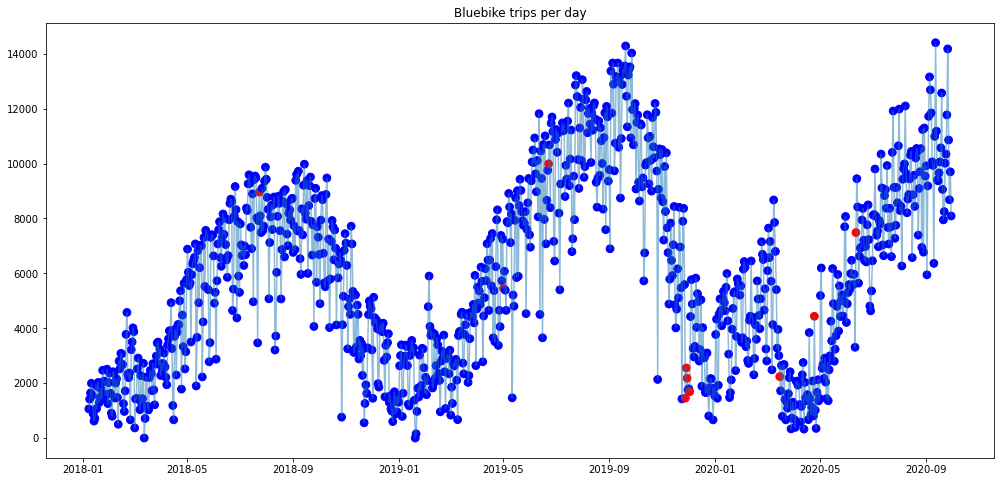

In [16]:
anomaly_plot(daily_data,daily_data_diff_IF,365,7)

We can see that our isolation forest now identifies the drop we observed in the middle of March as being anomalous based on historic data!

While the isolation forest is touted for its ability to deal with seasonal data, we observed that it still needed help with our time series. There are some more advanced [algorithms](https://www.sciencedirect.com/science/article/pii/S0925231217309864) that seem to be better suited for anomaly detection in noisy time series. Testing these methods would certainly be an interesting avenue to explore in an extension to this project.